In [1]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET


def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[4][0].text),
                     int(member[4][1].text),
                     int(member[4][2].text),
                     int(member[4][3].text)
                     )
            xml_list.append(value)
    column_name = ['image_names', 'width', 'height', 'label', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df


def main():
    image_path = os.path.join(os.getcwd(), 'annotations')
    xml_df = xml_to_csv(image_path)
    xml_df.to_csv('raccoon_labels.csv', index=None)
    print('Successfully converted xml to csv.')

In [2]:
path = "/content/drive/MyDrive/YOLO_V4/xml files"
df = xml_to_csv(path)

In [3]:
df.head()

,image_names,width,height,label,xmin,ymin,xmax,ymax
0,1.jpg,420,600,green,135,113,169,196
1,1.jpg,420,600,green,205,115,238,196
2,2.jpg,930,768,green,251,170,304,316
3,8.jpg,329,220,red,57,108,81,171
4,8.jpg,329,220,red,275,61,303,131


In [4]:
# import required libraries
import os
import numpy as np
import pandas as pd
import torch
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as pc

from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [5]:
df.head()

,image_names,width,height,label,xmin,ymin,xmax,ymax
0,1.jpg,420,600,green,135,113,169,196
1,1.jpg,420,600,green,205,115,238,196
2,2.jpg,930,768,green,251,170,304,316
3,8.jpg,329,220,red,57,108,81,171
4,8.jpg,329,220,red,275,61,303,131


In [6]:
# preprocessing data
# 1 - red
# 2 - yellow
# 3 - green
# 4 - off
data = df
data['label'] = data['label'].replace({'red': 1, 'yellow': 2, 'green': 3})
data = data.loc[(data['xmax'] > data['xmin'] + 20) | (data['ymax'] > data['ymin'] + 20)]

In [7]:
len(data)

46

In [8]:
# defining required transformations
from torchvision import transforms as TF

transform = TF.Compose([
    TF.ToTensor()
])

In [9]:
## convert list of list to tuple
def collate_fn(batch):
    return tuple(zip(*batch))

In [10]:
# defining class to load data
class TrafficLight(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files
        self.imgs = data.image_names.unique()

    def __getitem__(self, idx):
        # load images
        img_name = self.imgs[idx]
        img_path = os.path.join(self.root, img_name)
        img = Image.open(img_path)

        num_objs = data[data['image_names'] == img_name].shape[0]
        boxes = []
        label = []
        for i in range(num_objs):
            xmin = data[data['image_names'] == img_name]['xmin'].iloc[i]
            xmax = data[data['image_names'] == img_name]['xmax'].iloc[i]
            ymin = data[data['image_names'] == img_name]['ymin'].iloc[i]
            ymax = data[data['image_names'] == img_name]['ymax'].iloc[i]
            target = data[data['image_names'] == img_name]['label'].iloc[i]
            boxes.append([xmin, ymin, xmax, ymax])
            label.append(target)

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(label, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        if self.transforms is not None:
            img = self.transforms(img)
        #     boxes[:, 0] = boxes[:, 0] * (224/640)
        #     boxes[:, 2] = boxes[:, 2] * (224/640)
        #     boxes[:, 1] = boxes[:, 1] * (224/480)
        #     boxes[:, 3] = boxes[:, 3] * (224/480)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [11]:
dataset = TrafficLight('/content/drive/MyDrive/YOLO_V4/frames/',transform)

In [12]:
dataset

In [13]:
# defining data loader
data_loader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=2, 
    shuffle=False, 
    collate_fn=collate_fn
)

In [14]:
# testing for one iteration
for batch_x, batch_y in data_loader:
    break

In [15]:
batch_x[0].shape

torch.Size([3, 600, 420])

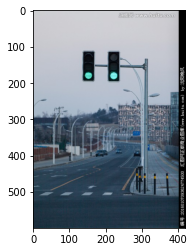

In [16]:
plt.imshow(np.transpose(batch_x[0], (1, 2, 0)))

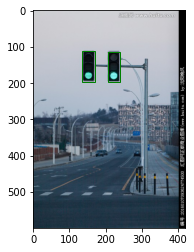

num Reds tensor(0)
num yellow tensor(0)
num green tensor(2)


In [17]:
# plot bounding box
plt.axes()
plt.imshow(np.transpose(batch_x[0], (1, 2, 0)))
for i in range(len(batch_y[0]['boxes'])):
    bbox = batch_y[0]['boxes'][i]
    x1, y1 = bbox[0], bbox[1]
    x2, y2 = bbox[2], bbox[3]

    if batch_y[0]['labels'][i] == 1:
        color = 'red'
    elif batch_y[0]['labels'][i] == 2:
        color = 'yellow'
    elif batch_y[0]['labels'][i] == 3:
        color = 'green'

    rectangle = pc.Rectangle((x1,y1), x2-x1, y2-y1, fc='none',ec=color)
    plt.gca().add_patch(rectangle)
plt.show()
print('num Reds', (batch_y[0]['labels'] == 1).sum())
print('num yellow', (batch_y[0]['labels'] == 2).sum())
print('num green', (batch_y[0]['labels'] == 3).sum())

# Defining Model

In [18]:
# define model
model = fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [19]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [20]:
num_classes = 4

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [21]:
# check model on one image
model.eval()
output = model(batch_x[0].view(1,3, 600, 420))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [22]:
output

[{'boxes': tensor([[163.4711, 363.1945, 221.7647, 410.0775],
          [146.7131, 383.5152, 200.9039, 402.7621],
          [211.7021, 377.2172, 254.5233, 396.4005],
          [169.7955, 382.0034, 228.6478, 401.4789],
          [192.8444, 371.0617, 238.6927, 391.0556],
          [146.4970, 380.2745, 260.5302, 405.5907],
          [218.4498, 379.9023, 269.1192, 400.3628],
          [ 65.5771, 323.8354, 409.8569, 375.3132],
          [175.2631, 376.4001, 199.4255, 405.3606],
          [271.5200, 377.8068, 296.0322, 404.8238],
          [187.6213, 374.9502, 232.1698, 399.0008],
          [335.0818, 380.9859, 340.3562, 388.3270],
          [ 29.4965, 349.1500, 325.4748, 399.4279],
          [ 70.8786, 117.2191, 245.2390, 191.0581],
          [208.8378, 334.2829, 228.4993, 388.9149],
          [198.3040, 340.4511, 362.8507, 365.0084],
          [188.9676, 349.9637, 341.5329, 372.4685],
          [261.3859, 317.9013, 316.4895, 514.1832],
          [174.2731, 340.9769, 215.5499, 404.8603],
   